# Titanic - Machine Learning from Disaster

## 1. Introduction

The Titanic dataset is one of the most famous datasets in the machine learning community. It contains information about the passengers aboard the Titanic, including their age, gender, class, and whether they survived the disaster. The goal of this project is to build a predictive model that can determine whether a passenger survived based on these features using the **MLP Classifier**

In this notebook, we will:

1. Load and preprocess the data.
2. Balance the dataset to handle class imbalance.
3. Split the data into training, validation, and test sets.
4. Train a Multilayer Perceptron (MLP) model.
5. Evaluate the model using a confusion matrix and classification report.

## 2. Loading and Preprocessing the Data

### 2.1 Loading the Data

First, we load the dataset using pandas. The dataset is stored in a CSV file named train.csv

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('train.csv')

# Display the first few rows of the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2.2 Handling Missing Values

The dataset contains missing values in columns like Age (19,8% missing), Cabin (77% missing) and Embarked (0,2% missing). We need to handle these missing values to ensure the model can process the data correctly.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Fill missing 'Age' values with the median age
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing 'Embarked' values with the mode (most common value)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Create a new column 'Has_Cabin' to indicate whether a passenger had a cabin
df['Has_Cabin'] = df['Cabin'].notnull().astype(int)

# Drop the 'Cabin' column, as it won't be used directly
df.drop('Cabin', axis=1, inplace=True)

# Check for remaining missing values
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Has_Cabin      0
dtype: int64

### 2.3 Encoding Categorical Variables

In [4]:
# Encode the 'Sex' column (male = 0, female = 1)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Use one-hot encoding for the 'Embarked' column
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked')

# Display the first few rows after encoding
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Has_Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,False,False,True
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,False,False,True


## 3. Balancing the Dataset
The dataset is imbalanced, with more examples of passengers who did not survive than those who did. To address this, we use oversampling to balance the classes.


### 3.1 Addressing Class Imbalance
The dataset is imbalanced, with more examples of passengers who did not survive than those who did. To address this, we use oversampling to balance the classes.

In [5]:
from imblearn.over_sampling import RandomOverSampler

# Separate features (X) and target (y)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X = df[features]
y = df['Survived']

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X, y)

# Check the class distribution after oversampling
y_balanced.value_counts()


Survived
0    549
1    549
Name: count, dtype: int64

## 4. Splitting the Data

### 4.1 Creating Training, Validation, and Test Sets
We split the balanced dataset into three parts:

- Training set (50%): Used to train the model.
- Validation set (25%): Used to tune hyperparameters and avoid overfitting.
- Test set (25%): Used to evaluate the final model.

In [6]:
from sklearn.model_selection import train_test_split

# Split the balanced data into training (50%) and temporary (50%)
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.5, random_state=42, stratify=y_balanced)

# Split the temporary data into validation (25%) and test (25%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the sizes of each set
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

Training set: 549
Validation set: 274
Test set: 275


## 5. Training the MLP Model

### 5.1 Building and Training the Model

We use a Multilayer Perceptron (MLP), a type of neural network, to predict survival. The model is trained on the training set and evaluated on the validation set.

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=2000, alpha=0.01, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = mlp.predict(X_val)

# Evaluate the model's performance
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 75.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       137
           1       0.75      0.77      0.76       137

    accuracy                           0.76       274
   macro avg       0.76      0.76      0.76       274
weighted avg       0.76      0.76      0.76       274



In [9]:
# Fazer previsões no conjunto de teste
y_test_pred = mlp.predict(X_test)

# Avaliar o desempenho no teste
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Acurácia no teste: {test_accuracy * 100:.2f}%")
print("\nRelatório de classificação no teste:")
print(classification_report(y_test, y_test_pred))

Acurácia no teste: 83.27%

Relatório de classificação no teste:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       138
           1       0.86      0.79      0.82       137

    accuracy                           0.83       275
   macro avg       0.84      0.83      0.83       275
weighted avg       0.84      0.83      0.83       275



## 6. Visualizing the Results

### 6.1 Confusion Matrix

A confusion matrix helps us understand how well the model is performing by showing the number of correct and incorrect predictions for each class.

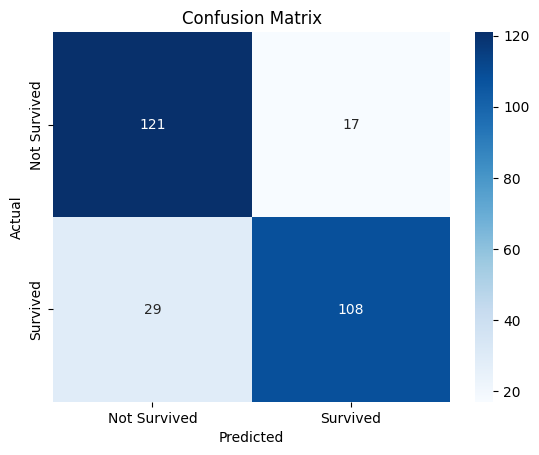

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()